In [90]:
from src.dataloader import *
from src.confusion_matrix import make_confusion_matrix

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn


import tensorflow as tf
import keras
import keras.layers as layers
from keras.losses import BinaryCrossentropy


In [2]:
tf.random.set_seed(42)

# Import des données

In [3]:
label_attribution=LabelAttribution(path_image_google="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", 
                                   path_mask_google='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/mask/',
                                   path_metadata='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/metadata.csv',
                                   colonne_identifiant='identifiant',
                                   path_export_train_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps",
                                   path_image_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/img',
                                   path_mask_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/mask/',
                                   use_img_google=True,
                                   use_img_ign=False
                                    )

In [4]:
label_attribution.run()

Le LeNET5 a été conçu pour prendre en entrée des images de dimension 28*28. On passe donc les images 400 x 400 en 28 x 28. On convertit ensuite ces dernières en tenseurs. 

In [5]:
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))
transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))

In [6]:
print("Nombre d'images dans le train: {}".format(transformed_train_dataset.__len__()))
print("Nombre d'images dans le test: {}".format(transformed_test_dataset.__len__()))

Nombre d'images dans le train: 23045
Nombre d'images dans le test: 5762


In [7]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=5762, shuffle=True)

# LeNet5: implémentation et apprentissage

## Absence de data augmentations

On entraîne le LeNet5 sans data augmentations. Nous fixons les hyper-paramètres de façon arbitraire dans un premier temps:
* Learning rate: 0,01
* Momentum: 0,9
* Dropout: 0,2
* epochs: 10
* batch size: 32

In [8]:
X_train, Y_train=next(iter(train_dataloader))
X_test, Y_test=next(iter(test_dataloader))

X_train_permute=X_train.permute(0, 2, 3,1)
X_test_permute=X_test.permute(0, 2, 3,1)

In [9]:
from src.lenet5 import buildModel

model_init=buildModel()

history=model_init.fit(x=X_train_permute.numpy(), y=Y_train.numpy(),
	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
	batch_size=32,
	epochs=10)

Epoch 1/10
721/721 [==============================] - 8s 10ms/step - loss: 0.5250 - Accuracy: 0.7535 - recall_m: 0.7826 - precision_m: 0.7687 - f1_m: 0.7657 - val_loss: 0.4448 - val_Accuracy: 0.8207 - val_recall_m: 0.8473 - val_precision_m: 0.8175 - val_f1_m: 0.8274
Epoch 2/10
721/721 [==============================] - 7s 9ms/step - loss: 0.4555 - Accuracy: 0.8098 - recall_m: 0.8288 - precision_m: 0.8175 - f1_m: 0.8176 - val_loss: 0.4348 - val_Accuracy: 0.8292 - val_recall_m: 0.8146 - val_precision_m: 0.8529 - val_f1_m: 0.8286
Epoch 3/10
721/721 [==============================] - 6s 9ms/step - loss: 0.4344 - Accuracy: 0.8203 - recall_m: 0.8318 - precision_m: 0.8303 - f1_m: 0.8263 - val_loss: 0.4141 - val_Accuracy: 0.8362 - val_recall_m: 0.8161 - val_precision_m: 0.8628 - val_f1_m: 0.8346
Epoch 4/10
721/721 [==============================] - 7s 9ms/step - loss: 0.4202 - Accuracy: 0.8263 - recall_m: 0.8337 - precision_m: 0.8385 - f1_m: 0.8316 - val_loss: 0.3921 - val_Accuracy: 0.8429 - v

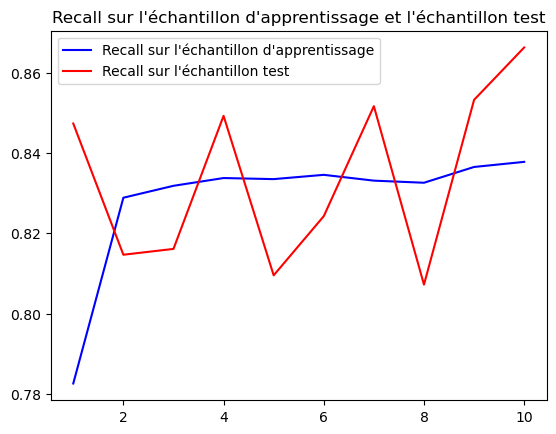

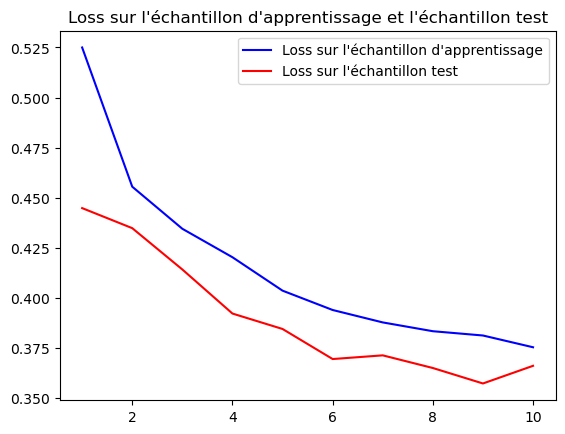

In [12]:
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(recall) + 1)

plt.plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
plt.plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
plt.title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
plt.plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
plt.title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.show()

In [13]:
loss, accuracy, recall, precision, f1score = model_init.evaluate(X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss,3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy,3)))
print("Recall sur l'échantillon test: {}".format(round(recall,3)))
print("Precision sur l'échantillon test: {}".format(round(precision,3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score,3)))

Loss sur l'échantillon test: 0.366
Accuracy sur l'échantillon test: 0.849
Recall sur l'échantillon test: 0.866
Precision sur l'échantillon test: 0.847
F1-score sur l'échantillon test: 0.853


In [14]:
prob_predict = model_init.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

181/181 [==============================] - 1s 5ms/step


In [15]:
y_pred

array([0, 0, 1, ..., 1, 1, 1])

In [16]:
unique, counts = np.unique(y_pred, return_counts=True)
res=dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Nombre d'images prédites avec panneaux: 3189
Nombre d'images prédites sans panneau: 2573


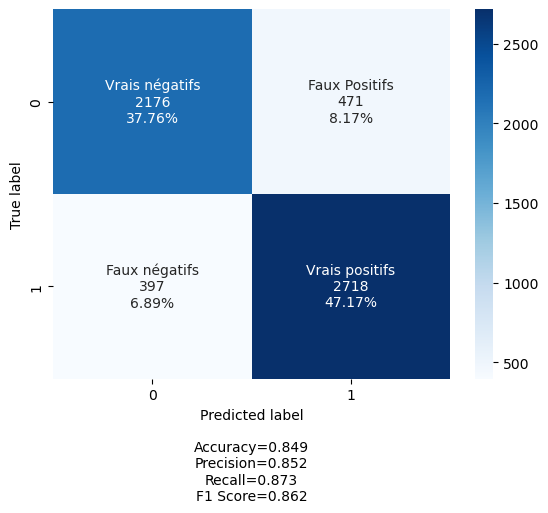

In [98]:
r = confusion_matrix(Y_test, y_pred)

labels = ["Vrais négatifs","Faux Positifs","Faux négatifs","Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r, 
                      group_names=labels,
                      categories=categories, 
                      )

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

FPR, TPR, thresholds_keras = roc_curve(Y_test.numpy(), prob_predict)
AUC = auc(FPR, TPR)
print("AUC: {}".format(round(AUC, 2)))

AUC: 0.92


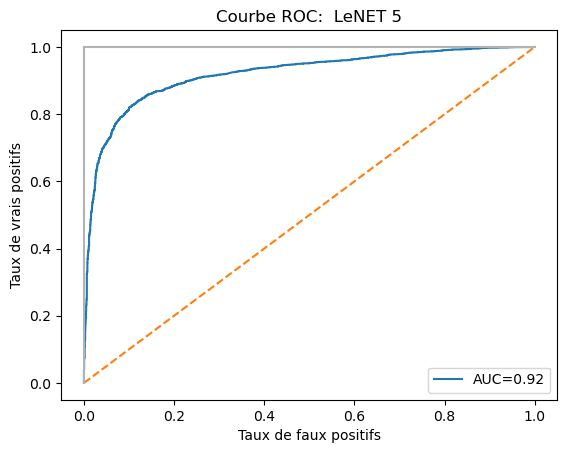

In [19]:
from matplotlib import pyplot as plt
# plot the roc curve for the model

plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()

## Ajout de data augmentations

In [20]:
transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.5, 0.5)),
                                               transforms.RandomCrop(20),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=0.5),
                                               transforms.RandomRotation(degrees = (0,180)),
                                               transforms.Resize(28),
                                               transforms.ToTensor(), 

                                           ]))

#On resize uniquement sur le test
transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))

In [21]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=5762, shuffle=True)

On normalise les données d'apprentissage et de test

In [22]:
mean_train, std_train = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))

Moyenne par channel: [0.2969593107700348, 0.29610514640808105, 0.29613879323005676]
Ecart-type par channel: [0.19015252590179443, 0.18941254913806915, 0.18982695043087006]


In [23]:
mean_test, std_test = mean_std(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))

Moyenne par channel: [0.3499923348426819, 0.3576664924621582, 0.3081061840057373]
Ecart-type par channel: [0.16761955618858337, 0.14885342121124268, 0.1473139077425003]


In [24]:
normalized_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=(-0.5, 0.5)),
                                               transforms.RandomCrop(20),
                                               transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.RandomVerticalFlip(p=0.5),
                                               transforms.RandomRotation(degrees = (0,180)),
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_train.tolist(),
                                                                    std= std_train.tolist()), 

                                           ]))


normalize_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_test.tolist(),
                                                                    std= std_test.tolist()), 
                                           ]))
train_dataloader_augmente = DataLoader(normalized_train_dataset, batch_size=23045, shuffle=True)
test_dataloader_augmente = DataLoader(normalize_test_dataset, batch_size=5762, shuffle=True)

## Apprentissage avec data augmentations

In [25]:
X_train_augmente, Y_train_augmente=next(iter(train_dataloader_augmente))
X_test_augmente, Y_test_augmente=next(iter(test_dataloader_augmente))

X_train_augmente_permute=X_train_augmente.permute(0, 2, 3,1)
X_test_augmente_permute=X_test_augmente.permute(0, 2, 3,1)

In [26]:
model_augmente=buildModel()

history_augmente=model_augmente.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
	validation_data=(X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
	batch_size=32,
	epochs=10)

Epoch 1/10
721/721 [==============================] - 7s 9ms/step - loss: 0.6761 - Accuracy: 0.5804 - recall_m: 0.6576 - precision_m: 0.5921 - f1_m: 0.6156 - val_loss: 0.6488 - val_Accuracy: 0.6430 - val_recall_m: 0.7197 - val_precision_m: 0.6574 - val_f1_m: 0.6811
Epoch 2/10
721/721 [==============================] - 6s 8ms/step - loss: 0.6638 - Accuracy: 0.6012 - recall_m: 0.6649 - precision_m: 0.6159 - f1_m: 0.6296 - val_loss: 0.6139 - val_Accuracy: 0.6762 - val_recall_m: 0.7515 - val_precision_m: 0.6818 - val_f1_m: 0.7099
Epoch 3/10
721/721 [==============================] - 6s 8ms/step - loss: 0.6409 - Accuracy: 0.6338 - recall_m: 0.6712 - precision_m: 0.6530 - f1_m: 0.6509 - val_loss: 0.5740 - val_Accuracy: 0.7149 - val_recall_m: 0.8690 - val_precision_m: 0.6871 - val_f1_m: 0.7636
Epoch 4/10
721/721 [==============================] - 6s 8ms/step - loss: 0.6131 - Accuracy: 0.6655 - recall_m: 0.7354 - precision_m: 0.6695 - f1_m: 0.6929 - val_loss: 0.5602 - val_Accuracy: 0.7180 - va

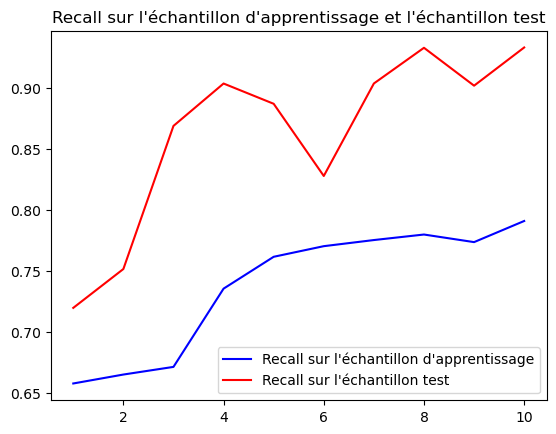

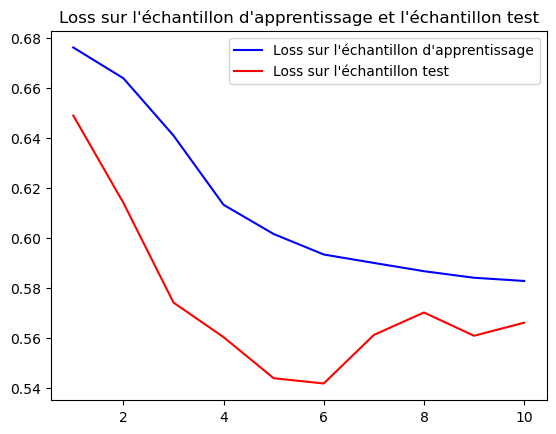

In [34]:
recall_augmente = history_augmente.history['recall_m']
val_recall_augmente = history_augmente.history['val_recall_m']
loss_augmente = history_augmente.history['loss']
val_loss_augmente = history_augmente.history['val_loss']
epochs_augmente = range(1, len(recall_augmente) + 1)

plt.plot(epochs_augmente, recall_augmente, 'b', label="Recall sur l'échantillon d'apprentissage")
plt.plot(epochs_augmente, val_recall_augmente, 'b', label="Recall sur l'échantillon test", color="red")
plt.title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.figure()
plt.plot(epochs_augmente, loss_augmente, 'b', label="Loss sur l'échantillon d'apprentissage")
plt.plot(epochs_augmente, val_loss_augmente, 'b', label="Loss sur l'échantillon test", color="red")
plt.title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.show()

In [35]:
loss_augmente, accuracy_augmente, recall_augmente, precision_augmente, f1score_augmente = model_augmente.evaluate(X_test_augmente_permute.numpy(), Y_test_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_augmente,3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_augmente,3)))
print("Recall sur l'échantillon test: {}".format(round(recall_augmente,3)))
print("Precision sur l'échantillon test: {}".format(round(precision_augmente,3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_augmente,3)))

Loss sur l'échantillon test: 0.566
Accuracy sur l'échantillon test: 0.708
Recall sur l'échantillon test: 0.933
Precision sur l'échantillon test: 0.664
F1-score sur l'échantillon test: 0.772


In [36]:
prob_predict_augmente = model_augmente.predict(X_test_augmente_permute.numpy())
y_pred_augmente = (np.squeeze(prob_predict_augmente) > 0.5).astype("int32")

181/181 [==============================] - 1s 4ms/step


In [30]:
unique_augmente, counts_augmente = np.unique(y_pred_augmente, return_counts=True)
res_augmente=dict(zip(unique_augmente, counts_augmente))
print("Nombre d'images prédites avec panneaux: {}".format(res_augmente[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_augmente[0]))

Nombre d'images prédites avec panneaux: 4385
Nombre d'images prédites sans panneau: 1377


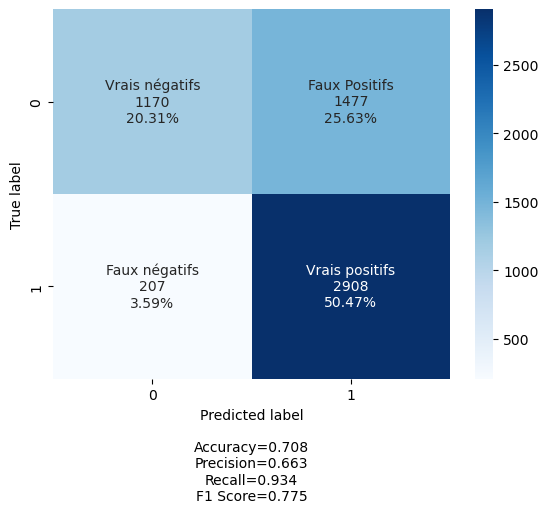

In [95]:

r = confusion_matrix(Y_test_augmente, y_pred_augmente)

labels = ["Vrais négatifs","Faux Positifs","Faux négatifs","Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r, 
                      group_names=labels,
                      categories=categories, 
                      )

In [32]:
FPR_augmente, TPR_augmente, thresholds_keras_augmente = roc_curve(Y_test_augmente.numpy(), prob_predict_augmente)
AUC_augmente = auc(FPR_augmente, TPR_augmente)
print("AUC: {}".format(round(AUC_augmente, 2)))

AUC: 0.78


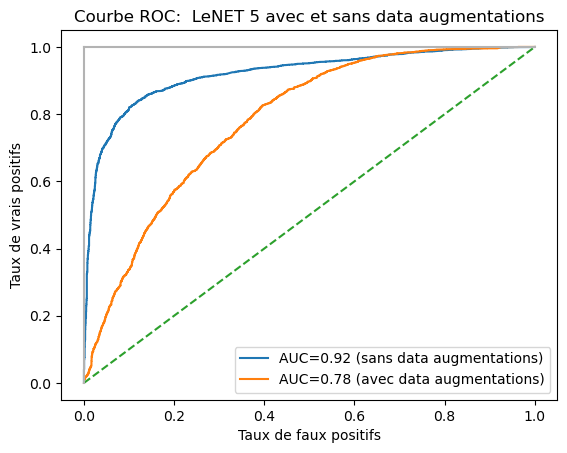

In [33]:
plt.title('Courbe ROC:  LeNET 5 avec et sans data augmentations')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC,2))+" (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC="+str(round(AUC_augmente,2))+" (avec data augmentations)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()

# Hyperparamétrisation du modèle: random search

https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

In [37]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

learnRate = [1e-2, 1e-3, 1e-4]
momentum=[0.9,0.99]
dropout1 = [0.1,0.2,0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]
dropout2 = [0.1,0.2,0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]
dropout3 = [0.1,0.2,0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]
dropout4 = [0.1,0.2,0.3, 0.4, 0.5,0.6,0.7,0.8,0.9]
batchSize = [4, 8, 16, 32, 64, 128, 256]
epochs = [10, 20, 30, 40,50]

grid = dict(
	learnRate=learnRate,
	momentum=momentum,
	dropout1=dropout1,
	dropout2=dropout2,
	dropout3=dropout3,
	dropout4=dropout4,
	batch_size=batchSize,
	epochs=epochs
)

model = KerasClassifier(build_fn=buildModel, verbose=1)
#grid = GridSearchCV(estimator=model, param_grid=hyperMatrix)

#n_iter: nombre de modèles entrainés
searcher = RandomizedSearchCV(estimator=model, cv=5, n_iter= 10, param_distributions=grid, scoring='recall')
searchResults = searcher.fit(X_train_augmente_permute.numpy(), Y_train_augmente.numpy())

Epoch 1/40
1153/1153 [==============================] - 9s 7ms/step - loss: 1.1712 - Accuracy: 0.5087 - recall_m: 0.5413 - precision_m: 0.5368 - f1_m: 0.5236
Epoch 2/40
1153/1153 [==============================] - 6s 5ms/step - loss: 1.2736 - Accuracy: 0.5100 - recall_m: 0.5442 - precision_m: 0.5392 - f1_m: 0.5266
Epoch 3/40
1153/1153 [==============================] - 8s 7ms/step - loss: 1.3057 - Accuracy: 0.5036 - recall_m: 0.5371 - precision_m: 0.5310 - f1_m: 0.5199
Epoch 4/40
1153/1153 [==============================] - 6s 5ms/step - loss: 1.2746 - Accuracy: 0.5082 - recall_m: 0.5469 - precision_m: 0.5370 - f1_m: 0.5267
Epoch 5/40
1153/1153 [==============================] - 8s 7ms/step - loss: 1.3077 - Accuracy: 0.5056 - recall_m: 0.5416 - precision_m: 0.5345 - f1_m: 0.5220
Epoch 6/40
1153/1153 [==============================] - 6s 5ms/step - loss: 1.3346 - Accuracy: 0.5042 - recall_m: 0.5353 - precision_m: 0.5340 - f1_m: 0.5190
Epoch 7/40
1153/1153 [==============================

In [38]:
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {} using {}".format(round(bestScore,3),
	bestParams))

[INFO] best score is 0.896 using {'momentum': 0.99, 'learnRate': 0.001, 'epochs': 20, 'dropout4': 0.1, 'dropout3': 0.7, 'dropout2': 0.7, 'dropout1': 0.6, 'batch_size': 32}


In [39]:
searchResults.cv_results_["mean_test_score"]

array([0.6096977 , 0.65432337, 0.66908522, 0.87451248, 0.6831274 ,
       0.66342882, 0.89580364, 0.80827022, 0.56416038, 0.60200855])

# Résultats sur le modèle optimisé

In [40]:
best_model=buildModel(learnRate=bestParams['learnRate'], dropout1=bestParams['dropout1'], dropout2=bestParams['dropout2'], dropout3=bestParams['dropout3'], dropout4=bestParams['dropout4'], momentum=bestParams['momentum'])

history_best=best_model.fit(x=X_train_augmente_permute.numpy(), y=Y_train_augmente.numpy(),
	validation_data=(X_test_augmente_permute.numpy(), Y_test_augmente.numpy()),
	batch_size=bestParams['batch_size'],
	epochs=bestParams['epochs'])

Epoch 1/20
721/721 [==============================] - 8s 10ms/step - loss: 0.6987 - Accuracy: 0.5471 - recall_m: 0.6466 - precision_m: 0.5611 - f1_m: 0.5937 - val_loss: 0.6458 - val_Accuracy: 0.6354 - val_recall_m: 0.7062 - val_precision_m: 0.6507 - val_f1_m: 0.6714
Epoch 2/20
721/721 [==============================] - 7s 10ms/step - loss: 0.6836 - Accuracy: 0.5617 - recall_m: 0.6567 - precision_m: 0.5761 - f1_m: 0.6052 - val_loss: 0.6315 - val_Accuracy: 0.6574 - val_recall_m: 0.7198 - val_precision_m: 0.6720 - val_f1_m: 0.6892
Epoch 3/20
721/721 [==============================] - 7s 9ms/step - loss: 0.6766 - Accuracy: 0.5841 - recall_m: 0.6452 - precision_m: 0.5994 - f1_m: 0.6139 - val_loss: 0.6255 - val_Accuracy: 0.6711 - val_recall_m: 0.7215 - val_precision_m: 0.6868 - val_f1_m: 0.6977
Epoch 4/20
721/721 [==============================] - 7s 10ms/step - loss: 0.6571 - Accuracy: 0.6189 - recall_m: 0.6582 - precision_m: 0.6372 - f1_m: 0.6383 - val_loss: 0.5818 - val_Accuracy: 0.7050 -

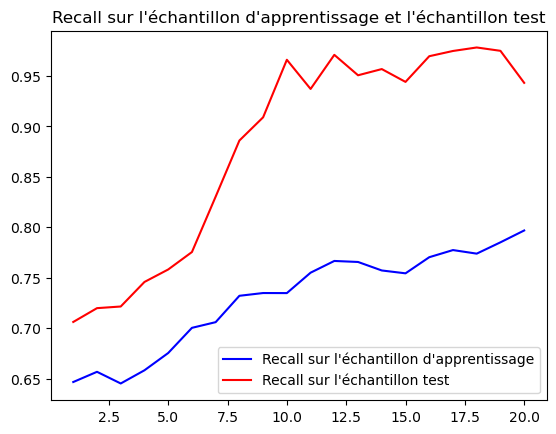

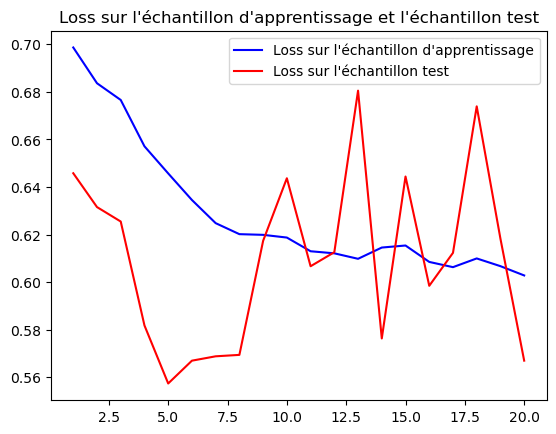

In [41]:
recall_best = history_best.history['recall_m']
val_recall_best = history_best.history['val_recall_m']
loss_best = history_best.history['loss']
val_loss_best = history_best.history['val_loss']
epochs_best = range(1, len(recall_best) + 1)

plt.plot(epochs_best, recall_best, 'b', label="Recall sur l'échantillon d'apprentissage")
plt.plot(epochs_best, val_recall_best, 'b', label="Recall sur l'échantillon test", color="red")
plt.title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.figure()
plt.plot(epochs_best, loss_best, 'b', label="Loss sur l'échantillon d'apprentissage")
plt.plot(epochs_best, val_loss_best, 'b', label="Loss sur l'échantillon test", color="red")
plt.title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
plt.legend()
plt.show()

In [63]:
loss_best, accuracy_best, recall_best, precision_best, f1score_best = best_model.evaluate(X_test_augmente_permute.numpy(), Y_test_augmente.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss_best,3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_best,3)))
print("Recall sur l'échantillon test: {}".format(round(recall_best,3)))
print("Precision sur l'échantillon test: {}".format(round(precision_best,3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score_best,3)))

Loss sur l'échantillon test: 0.567
Accuracy sur l'échantillon test: 0.714
Recall sur l'échantillon test: 0.943
Precision sur l'échantillon test: 0.668
F1-score sur l'échantillon test: 0.778


In [74]:
best_predict = best_model.predict(X_test_augmente_permute.numpy())
best_y_pred = (np.squeeze(best_predict) > 0.5).astype("int32")

181/181 [==============================] - 0s 3ms/step


In [76]:
uni_best, compteur_best = np.unique(best_y_pred, return_counts=True)
res_best=dict(zip(uni_best, compteur_best))
print("Nombre d'images prédites avec panneaux: {}".format(res_best[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_best[0]))

Nombre d'images prédites avec panneaux: 4405
Nombre d'images prédites sans panneau: 1357


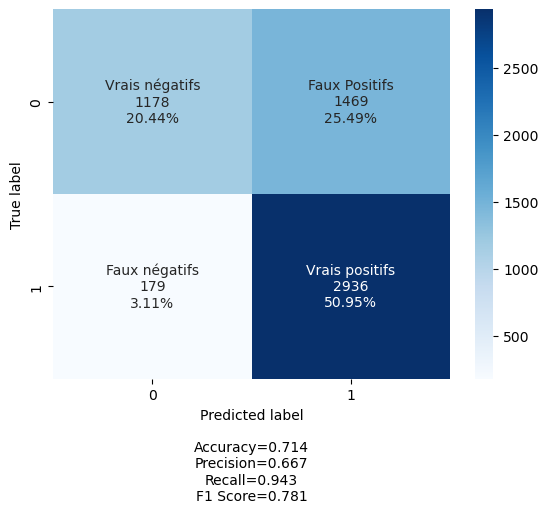

In [92]:
r = confusion_matrix(Y_test_augmente, best_y_pred)

labels = ["Vrais négatifs","Faux Positifs","Faux négatifs","Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r, 
                      group_names=labels,
                      categories=categories, 
                      )

In [93]:
FPR_best, TPR_best, thresholds_keras_best = roc_curve(Y_test_augmente.numpy(), best_predict)
AUC_best = auc(FPR_best, TPR_best)
print("AUC: {}".format(round(AUC_best, 2)))

AUC: 0.78


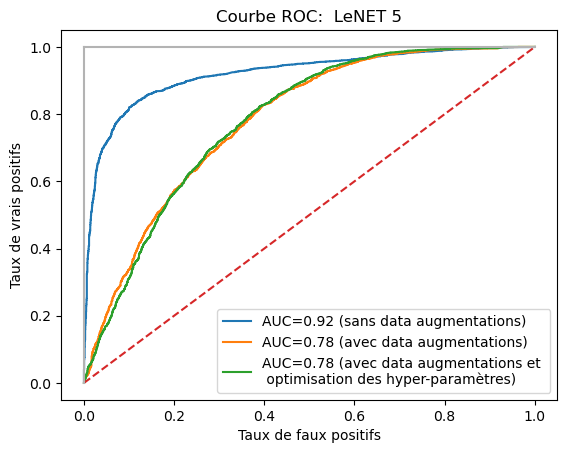

In [94]:
plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC,2))+" (sans data augmentations)")
plt.plot(FPR_augmente, TPR_augmente, label="AUC="+str(round(AUC_augmente,2))+" (avec data augmentations)")
plt.plot(FPR_best, TPR_best, label="AUC="+str(round(AUC_best,2))+" (avec data augmentations et \n optimisation des hyper-paramètres)")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()